# RBF version 


Lets define the RBF network

In [1]:
import pandas as pd
import scipy
import numpy as np
from sklearn.model_selection import train_test_split
# grid search, K-fold validation, fix seed
# find the model, but save the test loss and train loss for all the tried models
# create plot over parameter values and losses
import time

In [2]:
data = pd.read_csv('DATA (1).csv')
X_train, X_test, y_train, y_test = train_test_split(data[['x1','x2']], data[['y']], test_size=0.255, random_state=1990243)

In [3]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_tr = y_train.to_numpy()
y_te = y_test.to_numpy()

In [4]:
mat1 = np.random.normal(size=(2,4,2)) 
mat2 = np.array([[0,3],[1,2]])
res = (np.tile(mat2,(4,1)).reshape((2,4,2)))
print(np.linalg.norm(mat1, axis=-1))

[[1.18640664 1.87469813 1.5987876  0.6779267 ]
 [0.80844183 2.45385595 1.35369738 1.4245906 ]]


In [5]:
# sigma is a RBF spread parameter and simga > 0
def Gaussian(X, sigma):
    return np.exp(-(np.linalg.norm(X,axis = -1)/sigma)**2)

In [6]:
def RBF(W, args):
    sigma = args[1]
    X = args[2]
    C = W[0]
    v = W[1]
    #print(v.shape, Gaussian(X-C,sigma).shape)
    return np.matmul(v,Gaussian(X-C, sigma).T) 

In [7]:
def loss(W, args):
    N = args[0]
    if args[-1] == 1:
        a = args[-2]
        v = W
    elif args[-1] == 2:
        v = args[-2]
        a = W.reshape(1,N,2) 
    else:
        v = W[-N:]
        a = W[:-N].reshape(1,N,2)

    y = args[3]
#    c = np.repeat(a,args[2].shape[0],axis=1).reshape((args[2].shape[0],N,2)).T
    c = np.tile(a,(args[2].shape[0],1)).reshape(args[2].shape[0],N,2)

    regu = np.sum(a**2) + np.sum(v**2)
    loss = float((1/(2*len(args[2]))* np.sum((RBF((c,v), args) - y.T)**2, axis=1) + args[4]/2* regu)[0])
    #print(loss)
    return loss 

In [8]:
def grad_v(W, args):
    N = args[0]
    if args[-1] == 1:
        a = args[-2]
        v = W
    elif args[-1] == 2:
        v = args[-2]
        a = W.reshape(1,N,2) 
    else:
        v = W[-N:]
        a = W[:-N].reshape(1,N,2)

    y = args[3]
#    c = np.repeat(a,args[2].shape[0],axis=1).reshape((args[2].shape[0],N,2)).T
    c = np.tile(a,(args[2].shape[0],1)).reshape(args[2].shape[0],N,2)
    phi = Gaussian(args[2]-c, args[1])
    grads = phi.T @ (phi @ v - y.reshape(-1)) + len(args[2])*args[4]*v
    return grads

In [9]:
def grad_c(W, args):
    N = args[0]
    if args[-1] == 1:
        a = args[-2]
        v = W
    elif args[-1] == 2:
        v = args[-2]
        a = W.reshape(1,N,2) 
    else:
        v = W[-N:]
        a = W[:-N].reshape(1,N,2)

    y = args[3]
#    c = np.repeat(a,args[2].shape[0],axis=1).reshape((args[2].shape[0],N,2)).T
    c = np.tile(a,(args[2].shape[0],1)).reshape(args[2].shape[0],N,2)
    phi = Gaussian(args[2]-c, args[1])
    grads = phi.T @ (phi @ v - y.reshape(-1)) + len(args[2])*args[4]*v
    return grads

In [10]:
def preproc(N, X_train, hold = False, seed = 123): #n: the nr of neurons; hold: if we want the centers to be chosen from X_train
    np.random.seed(seed)
    if hold == True:

       a = X_train[np.random.choice(np.arange(X_train.shape[0]), N, replace=False)].reshape(1,N,2) 
    else:
        a =  np.random.normal(size=(1, N, 2))
    #res = np.tile(X_train,(N,1)).reshape((X_train.shape[0],N,2))
    res = np.repeat(X_train,N,axis=0).reshape(X_train.shape[0],N,2)
    
    
    #C = np.repeat(a,X_train.shape[0], axis=1).reshape(X_train.shape[0],N,2)
    

    v = np.random.normal(size = N)
    return a,v,res # a:centers;v: weights; res: train data with compatible shape


In [11]:
def func(W, args): #for plotting
    N = args[0]
    v = W[-N:]
    a = W[:-N].reshape(1,N,2)
    #c = np.repeat(a,args[2].shape[0],axis=1).reshape((args[2].shape[0],N,2))
    c = np.tile(a,(args[2].shape[0],1)).reshape(args[2].shape[0],N,2)


    return RBF((c,v), args)

In [12]:
def test_error(W,  args):
    N = args[0]
    v = W[-N:]
    a = W[:-N].reshape(1,N,2)
    y = args[3]
    #c = np.repeat(a,args[2].shape[0],axis=1).reshape((args[2].shape[0],N,2))
    c = np.tile(a,(args[2].shape[0],1)).reshape(args[2].shape[0],N,2)


    return float((1/(2*len(args[2]))* np.sum((RBF((c,v), args) - y.T)**2, axis=1)))

In [13]:
a = np.array([[1,2],[1,2],[1,2]])
b = np.array([1,2])
print(a.shape, b.shape)
np.matmul(a,b)

(3, 2) (2,)


array([5, 5, 5])

In [14]:
## main loop
rho = 1e-3
sigma =0.5 
N = 50 
seed = 123 #seed for weight initializtion
met = 'CG'
testing = 2 #which task are we testing

if testing == 1:
    C,V,res = preproc(N, X_train, seed= seed)
    print(len(res))
    shape = C.shape
    args = (N,sigma, res, y_tr, rho, shape,None, 0) #three modes: 0: both supervised; 1: centers unsupervised; 2:weights v unsupervised
    W = np.append(C.flatten(),V)
    print(loss(W, args))
    result_rbf = scipy.optimize.minimize(loss, W, args= (args,) , method=met, options = {"maxiter": 500})
elif testing == 2:
    C,V,res = preproc(N, X_train, 1, seed=seed)
    shape = C.shape
    args = (N,sigma, res, y_tr, rho, shape,C, 1) #three modes: 0: both supervised; 1: centers unsupervised; 2:weights v unsupervised
    W = V 
    print(loss(W, args))
    result_rbf = scipy.optimize.minimize(loss, W, args= (args,),jac=grad_v,  method=met)#, options = {"maxiter": 5})
else:
    C,V,res = preproc(N, X_train, 1, seed = seed)
    shape = C.shape
    args = (N,sigma, res, y_tr, rho, shape,C, 1) #three modes: 0: both supervised; 1: centers unsupervised; 2:weights v unsupervised
    W = V 
    print(loss(W, args))
    result_rbf = scipy.optimize.minimize(loss, W, args= (args,) , method=met)#, options = {"maxiter": 5})
    print(result_rbf)
    args = (N,sigma, res, y_tr, rho, shape,result_rbf.x, 2) #three modes: 0: both supervised; 1: centers unsupervised; 2:weights v unsupervised
    W = C
    print(loss(W, args))
    result_rbf = scipy.optimize.minimize(loss, W, args= (args,) , method=met)#, options = {"maxiter": 5})
print(result_rbf)




1.3449853393709228
     fun: 0.22656124103651004
     jac: array([-8.69856081e-07,  5.65610691e-07, -9.16441316e-08, -3.65037234e-07,
       -2.06185532e-06,  5.02659984e-07,  3.67033187e-06,  2.17052641e-06,
       -6.29762114e-08, -2.78262701e-06,  2.34863022e-06, -2.39277191e-06,
        1.08765376e-07, -6.18923998e-07, -3.18827483e-06, -2.22629321e-06,
        3.08953905e-06, -1.94279000e-06, -9.56972519e-06, -9.76037038e-06,
        6.34527396e-06, -3.53945684e-06, -5.58867318e-06, -1.14911017e-06,
       -4.36309420e-06,  1.17417843e-06,  4.12157327e-06, -9.90538533e-06,
        3.10742430e-06,  4.42550512e-07, -3.64270187e-06, -2.02474408e-06,
       -4.62387756e-07, -3.47698440e-07, -2.82928044e-06,  2.49137414e-06,
        2.12134928e-07,  6.43026416e-08, -1.23343408e-06, -2.82756928e-06,
       -1.88540750e-06, -9.87968825e-06,  7.62432288e-07, -1.13769720e-07,
        8.78309067e-07, -5.80167567e-08, -4.97002770e-06,  1.51278393e-06,
       -3.24392949e-06, -1.85402900e-06])

In [15]:
print(result_rbf)

     fun: 0.22656124103651004
     jac: array([-8.69856081e-07,  5.65610691e-07, -9.16441316e-08, -3.65037234e-07,
       -2.06185532e-06,  5.02659984e-07,  3.67033187e-06,  2.17052641e-06,
       -6.29762114e-08, -2.78262701e-06,  2.34863022e-06, -2.39277191e-06,
        1.08765376e-07, -6.18923998e-07, -3.18827483e-06, -2.22629321e-06,
        3.08953905e-06, -1.94279000e-06, -9.56972519e-06, -9.76037038e-06,
        6.34527396e-06, -3.53945684e-06, -5.58867318e-06, -1.14911017e-06,
       -4.36309420e-06,  1.17417843e-06,  4.12157327e-06, -9.90538533e-06,
        3.10742430e-06,  4.42550512e-07, -3.64270187e-06, -2.02474408e-06,
       -4.62387756e-07, -3.47698440e-07, -2.82928044e-06,  2.49137414e-06,
        2.12134928e-07,  6.43026416e-08, -1.23343408e-06, -2.82756928e-06,
       -1.88540750e-06, -9.87968825e-06,  7.62432288e-07, -1.13769720e-07,
        8.78309067e-07, -5.80167567e-08, -4.97002770e-06,  1.51278393e-06,
       -3.24392949e-06, -1.85402900e-06])
 message: 'Optimiz

In [16]:
###testing settings:
a,b, data_x = preproc(N,X_test)
data_y = y_te 
if testing == 2:
    W = np.append(C, result_rbf.x)
elif testing == 1:
    W = result_rbf.x
else:
    W = np.append(result_rbf.x, args[-2])

args = (N, sigma, data_x, data_y, rho, shape)
ter = test_error(W, args)
print(ter)

0.13037708756819497


(10000,)


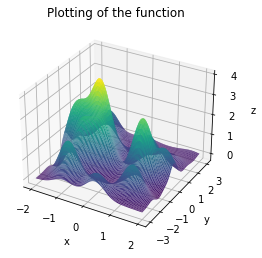

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
 

def plotting( title='Plotting of the function'): #if you do not provide a title, 'Plotting...' will be used
    #create the object
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    n = 100
    #create the grid
    x = np.linspace(-2, 2, n) #create 50 points between [-5,5] evenly spaced  
    y = np.linspace(-3, 3, n)
    X, Y = np.meshgrid(x, y) #create the grid for the plot
    mixed =  np.vstack((X.flatten(),Y.flatten())).T
    a,b,res = preproc(N,mixed)
    Z = func(W, (N, sigma,res,y_tr,rho ))#evaluate the function (note that X,Y,Z are matrix)
    print(Z.shape)
    Z = Z.reshape((n,n))
    #print(Z.shape)


    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='viridis', edgecolor='none')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(title)
    plt.show()

plotting()